# Supervised Shallow Machine Learning Models: XGBoost Regression

<div class="alert alert-info" role="alert" 
     style="font-size: 1.6em; font-weight: bold; padding: 10px; margin: 10px 0; text-align: center;">
    
    XGBoost model deployment -- Round 1
<div>

### Import Libraries including `sklearn`, `xgboost`, and `shap`

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import shap

# Data Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    New Data Preprocessing
</div>

### Load new data -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match the new CSV files
file_pattern = "cmems_testing_/cmems_mod_glo_phy-*_0.083deg_P1D-m.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    # Extract variable name: get text after 'cmems_mod_glo_phy-' and before the first underscore
    var_name = file.split("cmems_mod_glo_phy-")[-1].split("_")[0]
    df_dict[var_name.upper()] = pd.read_csv(file, comment='#')  # Use upper-case keys for consistency

# Process SSH separately (for Dates and renaming 'zos' to 'SSH')
# Assuming the SSH file is named like: cmems_mod_glo_phy-ssh_0.083deg_P1D-m.csv
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['Dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['Dates'] = SSH['Dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['Dates'] = pd.to_datetime(SSH['Dates'])
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})  # Rename 'zos' to 'SSH'
    SSH = SSH[['Dates', 'SSH']]  # Keep only 'Dates' and 'SSH'

# Mapping of expected variables to their corresponding column names in CSVs.
# Use upper-case keys to match our dictionary keys.
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Start with the SSH DataFrame if available; otherwise, create an empty one.
new_df = SSH.copy() if SSH is not None else pd.DataFrame()

# Loop through each expected variable, and add its values if available
for key, col in data_vars.items():
    # For velocities, assume the file is named with 'VEL' instead of the variable name
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key
    # Here, we assume that in the new files the key is simply the variable name (upper-case)
    if dataset_key in df_dict:
        new_df[key] = df_dict[dataset_key][col].values  # Assign the column values

# Print the first few rows to verify the result
print(new_df.head())

       Dates       SSH        SST        SSS       Vuo       Vvo        MLD
0 2022-06-01 -0.157100  28.285259  36.208824  0.214361  2.172305  11.826362
1 2022-06-02 -0.157860  28.619026  36.249100  0.250755  2.062931  15.236107
2 2022-06-03 -0.120291  28.477537  36.231472  0.390796  1.769881  12.486409
3 2022-06-04 -0.103189  28.041946  36.217098  0.292578  1.761578  11.842813
4 2022-06-05 -0.052188  28.271646  36.118107  0.315040  1.895313  16.884359


In [3]:
predictors = ['SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X_new = new_df[predictors].values     # Features
y_new = new_df['SST'].values          # True SST values
# Check reshaped data (n,n)(n,)
print(X_new.shape, y_new.shape)

(1028, 5) (1028,)


<div class="alert alert-info" role="alert" 
     style="font-size: 1.5em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Importing our saved XGBoost model
<div>

In [4]:
sst_model = xgb.XGBRegressor()              # Create new XGBoost regressor
sst_model.load_model("xgb_sst_model1.json")  # Load the model saved to disk

In [5]:
# Saved XGBoost model: predict 'new' SST
sst_pred = sst_model.predict(X_new)

# Evaluate model performance: 
# R², MSE, RMSE for new data
r2  = r2_score(y_new, sst_pred)
mse = mean_squared_error(y_new, sst_pred, squared = False)
rmse= np.sqrt(mse)

# Print output
print(f"XGBoost Deployment R²  : {r2:.2f}" )
print(f"XGBoost Deployment MSE : {mse:.2f}")
print(f"XGBoost Deployment RMSE: {rmse:.2f}")

XGBoost Deployment R²  : 0.49
XGBoost Deployment MSE : 1.57
XGBoost Deployment RMSE: 1.25


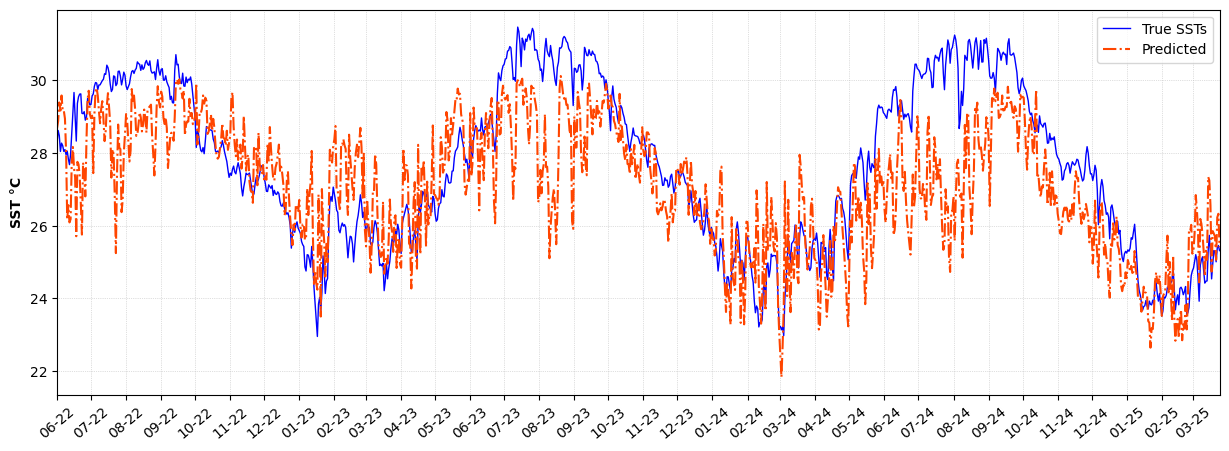

In [6]:
# Create Line plot
fig1, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot True and Predicted SSTs
ax.plot(new_df['Dates'], new_df['SST'], linestyle = '-', c = 'blue', linewidth = 1.0, label = 'True SSTs')
ax.plot(new_df['Dates'], sst_pred,linestyle = '-.', c = 'orangered', linewidth = 1.5, label = 'Predicted')

# Formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
ax.set_xlim([np.nanmin(new_df['Dates']), np.nanmax(new_df['Dates'])])
ax.set_ylabel('SST °C', fontsize = 10, weight = 'bold')
ax.legend();

# Set the x-axis major locator to every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
# Format the x-axis ticks as 'mm-yy'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation = 40, ha = 'center')

plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    
    Well that's pretty disappointing. It looks like our sst model is not capturing the seasonal cycle very well. 
    To be fair though, we didn't train the model on anything date related. Back to the training wheels for XGBoost!
    
    
<div>

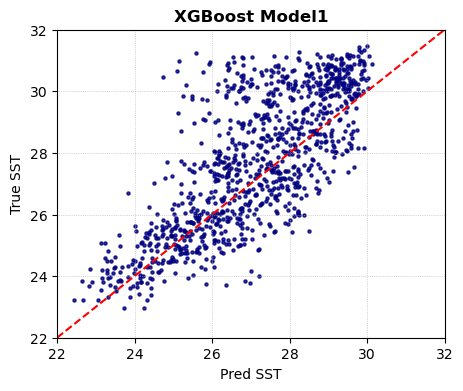

In [7]:
# Create Scatterplot
fig2, ax = plt.subplots(1, 1, figsize=(5, 4))
# Plot True and Predicted SSTs
ax.scatter(sst_pred, new_df['SST'], color = 'navy', alpha = 0.8, marker = 'o', s = 5)
# Set axes limits
ax.set_xlim(22, 32)
ax.set_ylim(22, 32)
# Plot a 1:1 line
ax.plot([22, 32], [22, 32], color = 'red', linestyle = '--', linewidth = 1.5)
# Formatting 
ax.set_xlabel('Pred SST')                           
ax.set_ylabel('True SST')                           
ax.set_title('XGBoost Model1', weight = 'bold')    
ax.grid(True, linestyle = ':', linewidth = 0.5) 

In [8]:
fig1.savefig('XBGBoost1_Lineplot.png', bbox_inches='tight')
fig2.savefig('XBGBoost1_Scatterp.png', bbox_inches='tight')